In [ ]:
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (DiagramBuilder, LinearQuadraticRegulator, Simulator, StartMeshcat, MeshcatVisualizer, 
ModelVisualizer, AddMultibodyPlantSceneGraph, Parser, RobotDiagramBuilder, Propeller,
    PropellerInfo,     RigidTransform,     namedview, ConstantVectorSource, LeafSystem, MathematicalProgram, PiecewisePolynomial, SnoptSolver,
    Adder, LeafSystem_, TemplateSystem, MeshcatAnimation,  DiscreteContactApproximation, VectorLogSink, LinearSystem, LinearSystem_, IsStabilizable,
    Expression, SnoptSolver, MathematicalProgram, DirectCollocation,Solve )

from underactuated import running_as_notebook, ConfigureParser
from quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint
from pydrake.examples import QuadrotorPlant, StabilizingLQRController, QuadrotorGeometry
from pydrake.geometry import SceneGraph

if running_as_notebook:
    mpld3.enable_notebook()
from IPython.display import HTML, SVG, display, Image
import pydot
import matplotlib.pyplot as plt


In [ ]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://fc21c6cf-7340-4587-8a5e-cf99745577e8.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [ ]:
@TemplateSystem.define("InputToPropeller_")
def InputToPropeller_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None, kF=None, kM=None,L=None):
            LeafSystem_[T].__init__(self, converter)
            print(T)
            self.input_port = self.DeclareVectorInputPort("input",4)
            self.output_port = self.DeclareVectorOutputPort(
                "propeller_command", 4, self.CalcPropellerCommand)

            self.kF = kF
            self.kM = kM
            self.L = L
            self.T=T


        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter, kF=other.kF, kM=other.kM, L=other.L)

        def CalcPropellerCommand(self, context, output):
            '''
            U1 = net thrust (float)
            U2 = roll command (float)
            U3 = pitch command (float)
            U4 = yaw command (float)
            '''
            inputs = self.input_port.Eval(context)
            U1, U2, U3, U4 = inputs

            kF = self.kF
            kM = self.kM
            L = self.L
       
            propeller_command = np.zeros(4)

            # Calculate rates of propellers
            w1 = 0.25 * (((U1 * kM[0] - U4 * kF[0]) * L[0] - 2*U3*kM[0]) / (kF[0] * kM[0] * L[0]))
            w2 = 0.25 * (((U1 * kM[1] + U4 * kF[1]) * L[1] - 2*U2*kM[1]) / (kF[1] * kM[1] * L[1]))
            w3 = 0.25 * (((U1 * kM[2] - U4 * kF[2]) * L[2] + 2*U3*kM[2]) / (kF[2] * kM[2] * L[2]))
            w4 = 0.25 * (((U1 * kM[3] + U4 * kF[3]) * L[3] + 2*U2*kM[3]) / (kF[3] * kM[3] * L[3]))

            # propeller_command[0] = kF[0] * w1
            # propeller_command[1] = kF[1] * w2
            # propeller_command[2] = kF[2] * w3
            # propeller_command[3] = kF[3] * w4
            output1 = kF[0] * w1
            output2 = kF[1] * w2
            output3 = kF[2] * w3
            output4 = kF[3] * w4

            if self.T is Expression:
                output[0] = output1
                output[1] = output2
                output[2] = output3
                output[3] = output4
            else:
                output[0] = max(min(output1,3),-3)
                output[1] = max(min(output2,3),-3)
                output[2] = max(min(output3, 3),-3)
                output[3] = max(min(output4, 3),-3)



    return Impl

InputToPropeller = InputToPropeller_[None]

In [ ]:
@TemplateSystem.define("RelativeState_")
def RelativeState_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None, L=1.0):
            LeafSystem_[T].__init__(self, converter)
           

            #Quadrotor state: x,y,z, rz, ry, rx (0-5)
            # Rod state-pos: x,y,z, (6-8)
            # Rod state-r: rz, ry, rx (9-11)
            # Quadrotor dot: qxdot, qydot, qzdot, qrzdot, qrydot, qrxdot (12-17)
            # Rod dot: xdot, ydot, zdot, rzdot ,rydot ,rxdot (18-23)

            self.real_quadrotor_pole_state = self.DeclareVectorInputPort("real_quadrotor_pole_state",24)
            
            # Quadpole Joint state: x,y,z,rz,ry,rx ; theta_x, theta_y ; v... ; theta_dot... 
            self.output_port = self.DeclareVectorOutputPort(
                "relative_state", 16, self.CalcRelativeState)

            self.pole_length = L


        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter, L=other.pole_length)

        def CalcRelativeState(self, context, output):
            quadrotor_pole_state = self.real_quadrotor_pole_state.Eval(context)

            ptheta_x = quadrotor_pole_state[11]
            ptheta_y = quadrotor_pole_state[10]
            ptheta_xdot = quadrotor_pole_state[23]
            ptheta_ydot = quadrotor_pole_state[22]
            
            for i in range(6):
                output[i] = quadrotor_pole_state[i]

            output[6] = ptheta_x
            output[7] = ptheta_y
            for i in range(8,14):
                output[i] = quadrotor_pole_state[i+4]

            output[14] = ptheta_xdot
            output[15] =  ptheta_ydot

            # print(f'rod-z: {quadrotor_pole_state[8]}')
            # print(f'Theta_x: {ptheta_x}')
            # print(f'Theta_xdot: {ptheta_xdot}')
            # print(f'Theta_y: {ptheta_y}')
            # print(f'Theta_ydot: {ptheta_ydot}')

    return Impl

RelativeState = RelativeState_[None]

In [ ]:
@TemplateSystem.define("SimpleQuadPoleSystem_")
def SimpleQuadPoleSystem_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None, pole_length=1.0):
            LeafSystem_[T].__init__(self, converter)
            # x,y,z, xdot,ydot,zot, r, rdot, qry
            # 0,  1,   2,  3,    4
            self.quadrotor_pole_state = self.DeclareContinuousState(5)
            
            # thrust, wx, wy, wz
            self.input_port = self.DeclareVectorInputPort("u",1)
            self.output_port = self.DeclareStateOutputPort(
                "state", self.quadrotor_pole_state)

            self.L = pole_length / 2
            self.g = -9.81


        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter, pole_length=other.L)

        # Derivatives for simplified system around nominal point and zero-yaw:
        # https://www.flyingmachinearena.ethz.ch/wp-content/publications/2011/hehn_dandrea_flying_inverted_pendulum.pdf
        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().GetAtIndex(0)
            xdot = context.get_continuous_state_vector().GetAtIndex(1)
            pr = context.get_continuous_state_vector().GetAtIndex(2)
            prdot = context.get_continuous_state_vector().GetAtIndex(3)
            qry = context.get_continuous_state_vector().GetAtIndex(4) # gamma

            wy = self.input_port.Eval(context)

            rdotdot = pr * self.g/self.L - qry * self.g
            xdotdot = qry * self.g
            qrydot = wy[0]
            
            print(rdotdot)

            derivatives.get_mutable_vector().SetAtIndex(1, xdotdot)
            derivatives.get_mutable_vector().SetAtIndex(3, rdotdot)
            derivatives.get_mutable_vector().SetAtIndex(4, qrydot)

        def CalcRelativeState(self, context, output):
            quadrotor_pole_state = self.quadrotor_pole_state.Eval(context)
            #self.real_quadrotor_pole_state.Eval(context)


            # r = pole deflection in along x axis in quadrotor frame
            # s = pole deflection in along y axis in quadrotor frame
            qpr = self.pole_length * np.sin(quadrotor_pole_state[6])
            qps = self.pole_length * np.sin(quadrotor_pole_state[7])
            qpr_dot = self.pole_length * np.cos(quadrotor_pole_state[6]) * quadrotor_pole_state[14]
            qps_dot = self.pole_length * np.cos(quadrotor_pole_state[7]) * quadrotor_pole_state[15]
            
            for i in range(6):
                output[i] = quadrotor_pole_state[i]

            output[6] = qpr
            output[7] = qps
            for i in range(8,14):
                output[i] = quadrotor_pole_state[i]

            # output[14] = qpr_dot
            # output[15] = qps_dot
            print(f'z: {quadrotor_pole_state[2]}')
            print(f'Theta: {quadrotor_pole_state[6]}')
            print(f'Thetadot: {quadrotor_pole_state[14]}')
            print(qpr, qps, qpr_dot, qps_dot)

    return Impl

SimpleQuadPoleSystem = SimpleQuadPoleSystem_[None]

In [ ]:
def MakeJugglePlant():
    # The RobotDiagram is a convenient way to work with a MultibodyPlant +
    # SceneGraph.
    builder = RobotDiagramBuilder(time_step=0.0001)
    plant = builder.plant()

    builder.parser().SetAutoRenaming(True)
    builder.parser().AddModels("quadrotor.urdf")
    builder.parser().AddModels("pole.sdf")

    # Floating joints are easier for LQR.
    quad1 = plant.GetModelInstanceByName("quadrotor")
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link", quad1),
        quad1,
        use_ball_rpy=False,
    )

    pole = plant.GetModelInstanceByName("pole")
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("upper_arm", pole),
        pole,
        use_ball_rpy=False,
    )
    

    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    quad1_body = plant.GetBodyByName("base_link", quad1).index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(quad1_body, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(quad1_body, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(quad1_body, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(quad1_body, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.builder().AddSystem(Propeller(prop_info))
    
    propeller_input = InputToPropeller(kF=[kF,kF,kF,kF],kM=[kM,kM,kM,kM],L=[L,L,L,L])
    
    builder.builder().AddSystem(propeller_input)

    builder.builder().Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )

    builder.builder().Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )

    builder.builder().Connect(
        propeller_input.get_output_port(),
        propellers.get_command_input_port(),
    )
    
    builder.builder().ExportInput(propeller_input.get_input_port(), "u")
    builder.builder().ExportOutput(plant.GetOutputPort("state"), "x")
    builder.builder().ExportOutput(
        builder.scene_graph().get_query_output_port(), "query"
    )
    
    return builder.Build()


def MakeBalancePlant(filename=""):
    # The RobotDiagram is a convenient way to work with a MultibodyPlant +
    # SceneGraph.
    builder = RobotDiagramBuilder(time_step=0.0001)
    plant = builder.plant()

    builder.parser().SetAutoRenaming(True)
    builder.parser().AddModels(f"{filename}.urdf")

    # Floating joints are easier for LQR.
    quad1 = plant.GetModelInstanceByName("quadrotor_pole")
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link", quad1),
        quad1,
        use_ball_rpy=False,
    )
    #plant.set_discrete_contact_approximation(DiscreteContactApproximation.kLagged)

    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    quad1_body = plant.GetBodyByName("base_link", quad1).index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.175  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(quad1_body, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(quad1_body, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(quad1_body, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(quad1_body, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.builder().AddSystem(Propeller(prop_info))
    
    propeller_input = InputToPropeller(kF=[kF,kF,kF,kF],kM=[kM,kM,kM,kM],L=[L,L,L,L])
    
    builder.builder().AddSystem(propeller_input)


    builder.builder().Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )

    builder.builder().Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )

    builder.builder().Connect(
        propeller_input.get_output_port(),
        propellers.get_command_input_port(),
    )
    
    # builder.builder().Connect(
    #     plant.GetOutputPort("quadrotor_pole_state"),
    #     state_converter.GetInputPort("quadrotor_pole_state")
    # )

    builder.builder().ExportInput(propeller_input.get_input_port(), "u")
    # builder.builder().ExportInput(state_converter.GetInputPort("real_quadrotor_pole_state"), "x_real")
    # builder.builder().ExportOutput(state_converter.GetOutputPort("relative_state"), "x")
    builder.builder().ExportOutput(plant.GetOutputPort("quadrotor_pole_state"), "x")
    builder.builder().ExportOutput(
        builder.scene_graph().get_query_output_port(), "query"
    )
    
    return builder.Build()



<class 'float'>
<class 'pydrake.symbolic.Expression'>
['quadrotor_pole_x_x', 'quadrotor_pole_y_x', 'quadrotor_pole_z_x', 'quadrotor_pole_rz_q', 'quadrotor_pole_ry_q', 'quadrotor_pole_rx_q', 'quadrotor_pole_theta_x_q', 'quadrotor_pole_theta_y_q', 'quadrotor_pole_x_v', 'quadrotor_pole_y_v', 'quadrotor_pole_z_v', 'quadrotor_pole_rz_w', 'quadrotor_pole_ry_w', 'quadrotor_pole_rx_w', 'quadrotor_pole_theta_x_w', 'quadrotor_pole_theta_y_w']
-9.81
0.505
test1
<class 'pydrake.autodiffutils.AutoDiffXd'>
test2
<class 'float'>
<class 'pydrake.symbolic.Expression'>
['quadrotor_x_x', 'quadrotor_y_x', 'quadrotor_z_x', 'quadrotor_rz_q', 'quadrotor_ry_q', 'quadrotor_rx_q', 'pole_x_x', 'pole_y_x', 'pole_z_x', 'pole_rz_q', 'pole_ry_q', 'pole_rx_q', 'quadrotor_x_v', 'quadrotor_y_v', 'quadrotor_z_v', 'quadrotor_rz_w', 'quadrotor_ry_w', 'quadrotor_rx_w', 'pole_x_v', 'pole_y_v', 'pole_z_v', 'pole_rz_w', 'pole_ry_w', 'pole_rx_w']


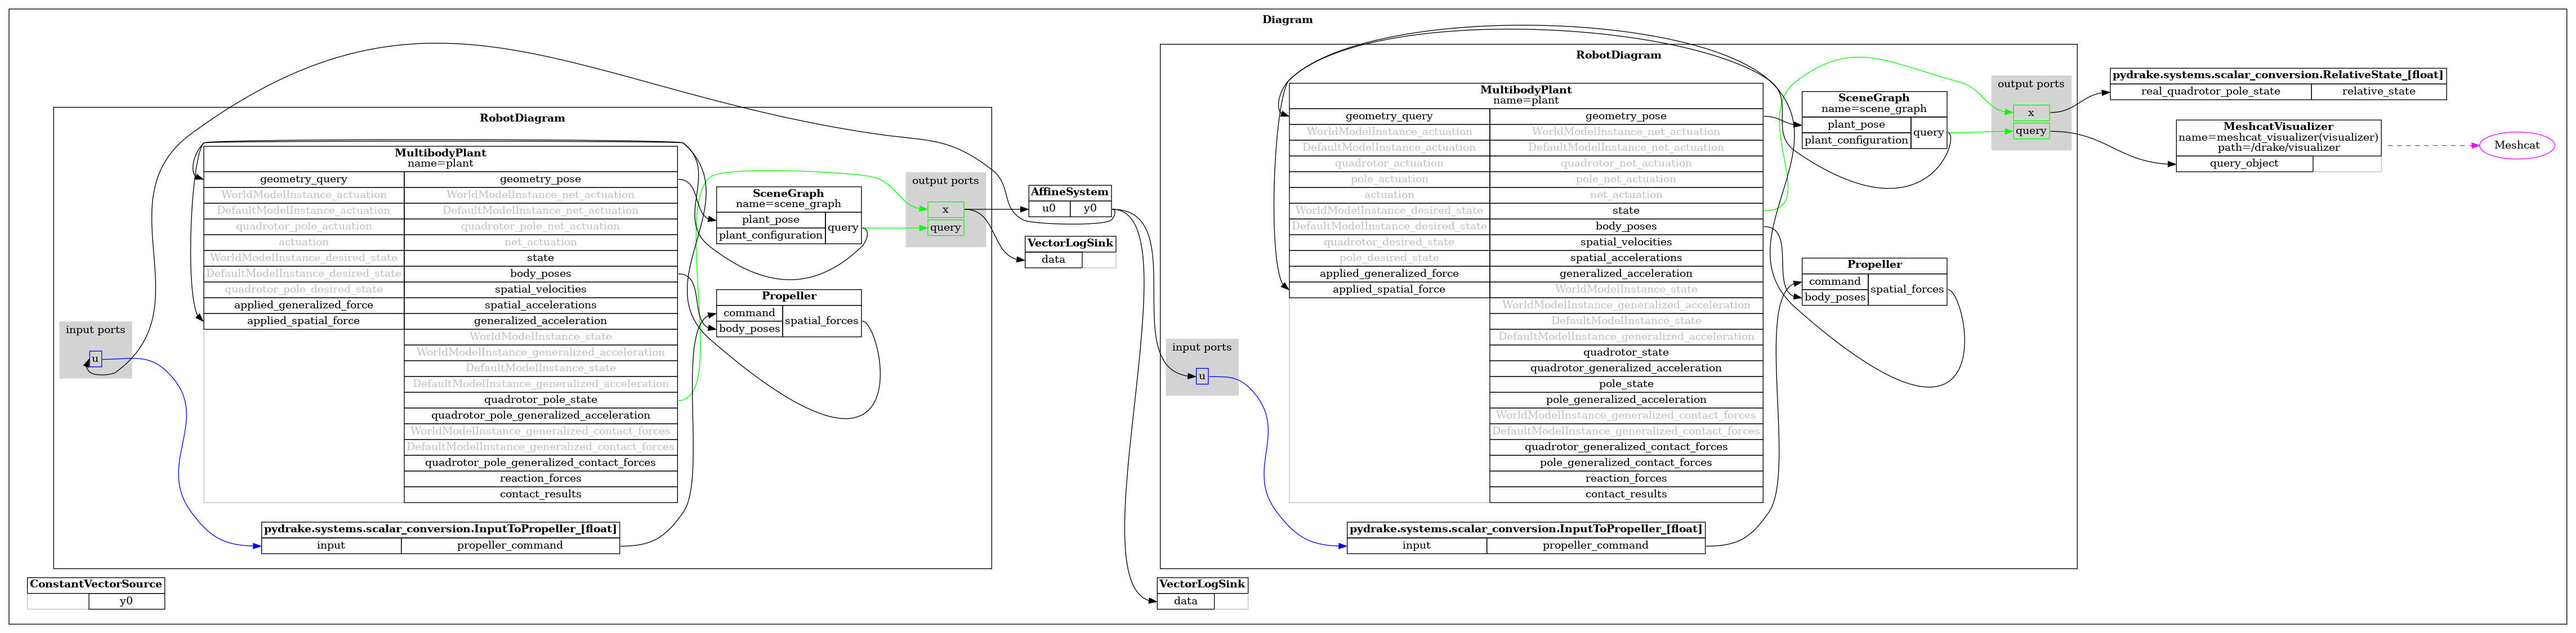

(5001,)
(5001,)
(5001,)


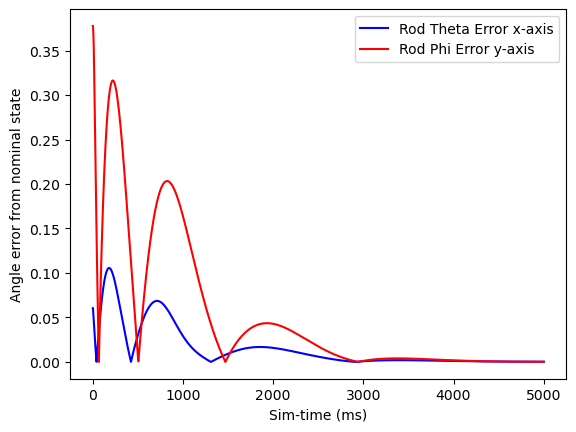

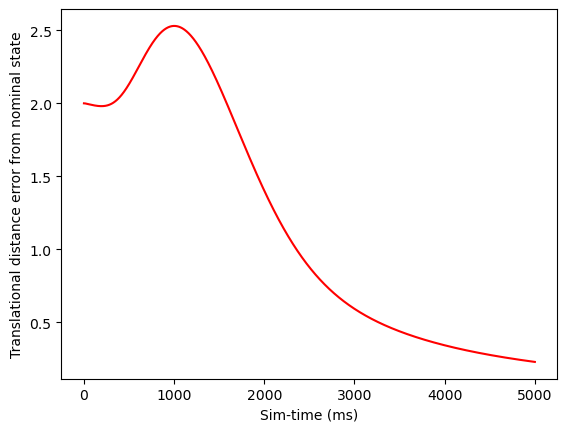

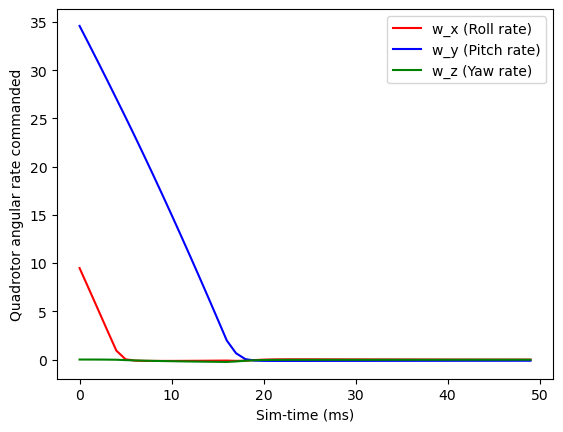

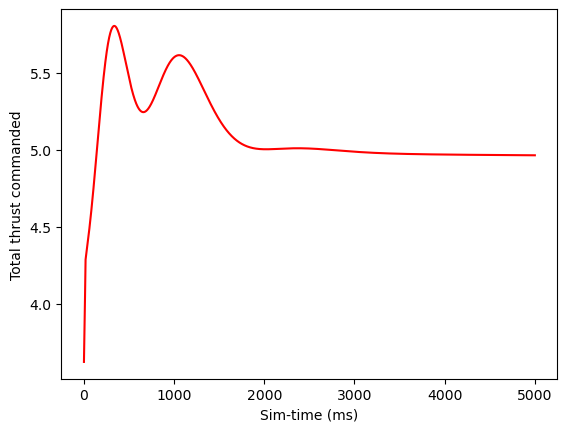

In [ ]:
def BalanceDemo(sim=False):
    builder = DiagramBuilder()

    robot_diagram= MakeBalancePlant("quadrotor_pole")

    builder.AddSystem(robot_diagram)
    plant = robot_diagram.plant()

    pole_length=1
    state_converter = RelativeState(L=pole_length)
    builder.AddSystem(state_converter)
    output_viewer = VectorLogSink(input_size=16, publish_period=0.001)

    LQR_viewer = VectorLogSink(input_size=4, publish_period=0.001)
    builder.AddSystem(output_viewer)
    builder.AddSystem(LQR_viewer)

    StateView = namedview("quadrotor_state", plant.GetStateNames(add_model_instance_prefix=True))
    x0 = StateView.Zero()
    x0.quadrotor_pole_x_x = 0
    x0.quadrotor_pole_z_x = 0
    plant.SetDefaultPositions(x0[: plant.num_positions()])
    print(plant.GetStateNames(add_model_instance_prefix=True))

    robot_diagram_context = robot_diagram.CreateDefaultContext()
    
    mass = plant.CalcTotalMass(
        plant.GetMyContextFromRoot(robot_diagram_context),
        [plant.GetModelInstanceByName("quadrotor_pole")],
    )
    gravity = plant.gravity_field().gravity_vector()[2]
    print(gravity)
    print(mass)
    nominal_input = [-mass * gravity, 0, 0, 0]
    robot_diagram.GetInputPort("u").FixValue(robot_diagram_context, nominal_input)

    Q = np.diag(np.concatenate(([10,10,1,1,1,1], [10] * 2, [10]*6, [10] * 2)))
    R = np.diag([1,1,1,1])

    print("test1")
    controller = builder.AddSystem(
        LinearQuadraticRegulator(robot_diagram, robot_diagram_context, Q, R)
    )

    controller2 = builder.AddSystem(
         ConstantVectorSource(nominal_input)
    )
    print("test2")

    robot_diagram_j = builder.AddSystem(MakeJugglePlant())

    plant_j = robot_diagram_j.plant()

    # We'll use a namedview to make it easier to work with the state.
    StateView = namedview("quadrotor_state", plant_j.GetStateNames(add_model_instance_prefix=True))
    x0_j = StateView.Zero()
    x0_j.quadrotor_x_x = 0
    x0_j.quadrotor_z_x = 0
    plant_j.SetDefaultPositions(x0_j[: plant_j.num_positions()])
    print(plant_j.GetStateNames(add_model_instance_prefix=True))

    robot_diagram_context_j = robot_diagram_j.CreateDefaultContext()

    mass_j = plant_j.CalcTotalMass(
        plant_j.GetMyContextFromRoot(robot_diagram_context_j),
        [plant_j.GetModelInstanceByName("quadrotor"), plant_j.GetModelInstanceByName("pole")],
    )
    gravity_j = plant_j.gravity_field().gravity_vector()[2]
    nominal_input_j = [-mass_j * gravity_j / 4] * 4
    robot_diagram_j.get_input_port().FixValue(robot_diagram_context_j, nominal_input_j)

    builder.Connect(robot_diagram_j.GetOutputPort("x"), state_converter.get_input_port())
    builder.Connect(robot_diagram.GetOutputPort("x") ,output_viewer.get_input_port())
    builder.Connect(controller.get_output_port() ,LQR_viewer.get_input_port())


    builder.Connect(controller.get_output_port(), robot_diagram_j.get_input_port())
    builder.Connect(controller.get_output_port(), robot_diagram.get_input_port())
    builder.Connect(robot_diagram.GetOutputPort("x"), controller.get_input_port())
    #builder.Connect(state_converter.get_output_port(), controller.get_input_port())
    
    MeshcatVisualizer.AddToBuilder(
        builder, robot_diagram_j.GetOutputPort("query"), meshcat
    )


    diagram = builder.Build()
    display(Image(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_png()))
    if sim:
        
        
        simulator = Simulator(diagram)
        simulator.set_target_realtime_rate(1 if running_as_notebook else 0.0)
        context = simulator.get_mutable_context()

        meshcat.StartRecording()
        # Simulate
        distances = []
        wxs = []
        wys = []
        wzs = []
        thrusts = []
        thetas = []
        phis = []

        for i in range(3):
            
            context.SetTime(0.0)
            total_distance_squared = 16

            x = np.random.uniform(0,16)
            y = np.random.uniform(0,16-x)
            z = 16-x-y

            x,y,z = (x**0.5,y**0.5,z**0.5)

            theta_x = np.random.uniform(-np.pi/4,np.pi/4)
            theta_y = np.random.uniform(-np.pi/4,np.pi/4)

            context.SetDiscreteState(0,
                # Quadrotor state: x,y,z, rz, ry, rx, theta_x. theta_y
                0.5* np.concatenate([np.array([x,y, z
                ,0,0,0, theta_x, theta_y]),
                # Quadrotor forces: fx, fy, fz, frz, fry, frx, ftheta_x,ftheta_y
                np.array([0,0,0, 0,0,0, 0, 0]),])
            )

            context.SetDiscreteState(1,
                # Quadrotor state: x,y,z, rz, ry, rx
                0.5* np.concatenate([np.array([0,0,0,0,0,0]),
                # Rod state-r: x,y,z, 
                np.array([0,0,1.06]),
                # Rod state-pos: rz, ry, rx
                np.array([0,0,0.01]),

                # Quadrotor forces: fx, fy, fz, frz, fry, frx
                np.array([0,0,0,0,0,0]),
                # Rod forces: fx, fy, fz, frz ,fry ,frx
                np.array([0,0,0,0,0,0])])
            )

            

            simulator.Initialize()
            try:
                simulator.AdvanceTo(5 if running_as_notebook else 0.1)
                contexto = output_viewer.GetMyContextFromRoot(context)
                contextlqr = LQR_viewer.GetMyContextFromRoot(context)
                log = np.array(output_viewer.GetLog(contexto).data()).T[i*5001:,:]
                control_log = np.array(LQR_viewer.GetLog(contextlqr).data()).T[i*5001:,:]

                theta_x_diff = np.abs(log[:,6]-0)
                theta_y_diff = np.abs(log[:,7]-0)
                dist_diff = ((log[:,0]-0)**2 + (log[:,1]-0)**2 + (log[:,2]-0)**2)**0.5
                thrust = control_log[:,0]
                wx = control_log[:,1]
                wy = control_log[:,2]
                wz = control_log[:,3]
                print(dist_diff.shape)

                distances.append(dist_diff)
                wxs.append(wx)
                wys.append(wy)
                wzs.append(wz)
                thrusts.append(thrust)
                thetas.append(theta_x_diff)
                phis.append(theta_y_diff)


                t = np.arange(0,log.shape[0],1)
            except: 
                contexto = output_viewer.GetMyContextFromRoot(context)
                contextlqr = LQR_viewer.GetMyContextFromRoot(context)
                log = np.array(output_viewer.GetLog(contexto).data()).T[i*5001:,:]
                control_log = np.array(LQR_viewer.GetLog(contextlqr).data()).T[i*5001:,:]

                theta_x_diff = np.abs(log[:,6]-0)
                theta_y_diff = np.abs(log[:,7]-0)
                dist_diff = ((log[:,0]-0)**2 + (log[:,1]-0)**2 + (log[:,2]-0)**2)**0.5
                thrust = control_log[:,0]
                wx = control_log[:,1]
                wy = control_log[:,2]
                wz = control_log[:,3]
                print(dist_diff.shape)

                distances.append(dist_diff)
                wxs.append(wx)
                wys.append(wy)
                wzs.append(wz)
                thrusts.append(thrust)
                thetas.append(theta_x_diff)
                phis.append(theta_y_diff)


                t = np.arange(0,log.shape[0],1)

        # print(np.stack(distances).shape)
        # dist_diff = np.mean(np.stack(distances),axis=0)
        # theta_x_diff = np.mean(np.stack(thetas),axis=0)
        # theta_y_diff = np.mean(np.stack(phis),axis=0)
        # thrust = np.mean(np.stack(thrusts),axis=0)
        # wx = np.mean(np.stack(wxs),axis=0)
        # wy = np.mean(np.stack(wys),axis=0)
        # wz = np.mean(np.stack(wzs),axis=0)

        meshcat.StopRecording()
        meshcat.PublishRecording()
        

        plt.plot(t, theta_x_diff, color='blue', label='Rod Theta Error x-axis')

        # Plotting the second line
        plt.plot(t, theta_y_diff, color='red', label='Rod Phi Error y-axis')

        # Adding labels
        plt.xlabel('Sim-time (ms)')
        plt.ylabel('Angle error from nominal state')

        # Adding a legend
        plt.legend()

        # Display the plot
        plt.show()

        # Display distance plot
        plt.figure() 
        plt.plot(t, dist_diff, color='red')
        plt.xlabel('Sim-time (ms)')
        plt.ylabel('Translational distance error from nominal state')
        
        # Display the plots
        plt.show()

        plt.figure() 
        plt.plot(t[:50], wx[:50], color='red', label='w_x (Roll rate)')
        plt.plot(t[:50], wy[:50], color='blue', label='w_y (Pitch rate)')
        plt.plot(t[:50], wz[:50], color='green', label='w_z (Yaw rate)')
        plt.xlabel('Sim-time (ms)')
        plt.ylabel('Quadrotor angular rate commanded')
        plt.legend()
        # Display the plots
        plt.show()

        plt.figure() 
        plt.plot(t, thrust, color='red')
        plt.xlabel('Sim-time (ms)')
        plt.ylabel('Total thrust commanded')

        # Display the plots
        plt.show()
    return diagram





BalanceDemo(sim=True)

In [ ]:
#['quadrotor_x_x', 'quadrotor_y_x', 'quadrotor_z_x', 'quadrotor_rz_q', 'quadrotor_ry_q', 
#'quadrotor_rx_q', 'pole_x_x', 'pole_y_x', 'pole_z_x', 'pole_rz_q', 'pole_ry_q', 'pole_rx_q', 
#'quadrotor_x_v', 'quadrotor_y_v', 'quadrotor_z_v', 'quadrotor_rz_w', 'quadrotor_ry_w', 'quadrotor_rx_w', 
#'pole_x_v', 'pole_y_v', 'pole_z_v', 'pole_rz_w', 'pole_ry_w', 'pole_rx_w']

# Quadrotor state: x,y,z, rz, ry, rx, theta_x. theta_y
# 0.5* np.concatenate([np.array([0,0,0 ,0,0,0, 0.1, 0]),
# Quadrotor forces: fx, fy, fz, frz, fry, frx, ftheta_x,ftheta_y
def Balancing():

    builder = DiagramBuilder()
    system = MakeBalancePlant("quadrotor_pole")
    builder.AddSystem(system)

    named_view = namedview("quadrotor_state", system.plant().GetStateNames(add_model_instance_prefix=True))

    MeshcatVisualizer.AddToBuilder(
        builder, system.GetOutputPort("query"), meshcat
    )
    meshcat.Delete()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    x_traj = None
    u_traj = None
    for N in [25, 41]:
        dircol = DirectCollocation(
                system, system.CreateDefaultContext(), N, 0.5 / N, 2.0 / N
            )
        prog = dircol.prog()
        dircol.AddEqualTimeIntervalsConstraints()

        u = dircol.input()
        max_angular_rate_limit = np.pi
        max_thrust_limit = 10

        dircol.AddConstraintToAllKnotPoints(-max_thrust_limit <= u[0])
        dircol.AddConstraintToAllKnotPoints(u[0] <= max_thrust_limit)

        dircol.AddConstraintToAllKnotPoints(-max_angular_rate_limit <= u[1])
        dircol.AddConstraintToAllKnotPoints(u[1] <= max_angular_rate_limit)

        dircol.AddConstraintToAllKnotPoints(-max_angular_rate_limit <= u[2])
        dircol.AddConstraintToAllKnotPoints(u[2] <= max_angular_rate_limit)

        dircol.AddConstraintToAllKnotPoints(-max_angular_rate_limit <= u[3])
        dircol.AddConstraintToAllKnotPoints(u[3] <= max_angular_rate_limit)

        s0 = named_view(np.zeros(16))
        s0.quadrotor_pole_theta_x_q = 0.05

        prog.AddBoundingBoxConstraint(s0[:], s0[:], dircol.initial_state())
        context.SetContinuousState(s0[:])
        diagram.ForcedPublish(context)

        # Final State
        sf = named_view(dircol.final_state())
        ptol = 0.05
        

        # State Constraints
        s = named_view(dircol.state())
        dircol.AddConstraintToAllKnotPoints(
            s.quadrotor_pole_rz_w == 0
        )
        dircol.AddConstraintToAllKnotPoints(
            s.quadrotor_pole_z_x >= 0
        )
        dircol.AddConstraintToAllKnotPoints(
            s.quadrotor_pole_theta_y_q >= -ptol * 2
        )
        dircol.AddConstraintToAllKnotPoints(
            s.quadrotor_pole_theta_y_q <= ptol * 2
        )
        dircol.AddConstraintToAllKnotPoints(
            s.quadrotor_pole_theta_x_q >= -ptol * 2
        )
        dircol.AddConstraintToAllKnotPoints(
            s.quadrotor_pole_theta_x_q <= ptol * 2
        )

        
        print("help")
        print(u)
        # Cost
        dircol.AddRunningCost(100 * u[1]**2)
        dircol.AddRunningCost(100 * u[2]**2)
        dircol.AddRunningCost(100 * u[3]**2)
        print("here")
        sf_d = named_view(np.zeros(16))
        sf_d.quadrotor_pole_theta_y_q = 0
        sf_d.quadrotor_pole_theta_x_q = 0
        prog.AddQuadraticErrorCost(
            np.diag([10,10,1,1,1,1, 10,10, 1,1,1,1,1,1,  10,10,]), sf_d[:], dircol.final_state()
        )
        print("planning")
        if x_traj and u_traj:
            dircol.SetInitialTrajectory(u_traj, x_traj)
        else:
            initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
                [0.0, 0.8], np.column_stack((s0[:], sf_d[:]))
            )
            dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
        result = Solve(prog)
        assert result.is_success()

        print(result)
        x_traj = dircol.ReconstructStateTrajectory(result)
        u_traj = dircol.ReconstructInputTrajectory(result)

    
    vizualizer = Simulator(diagram)
    vizualizer.set_target_realtime_rate(1 if running_as_notebook else 0.0)
    context = vizualizer.get_mutable_context()
    visualizer.StartRecording()
    for t in np.hstack(
        (
            np.arange(x_traj.start_time(), x_traj.end_time(), 1.0 / 32.0),
            x_traj.end_time(),
        )
    ):
        context.SetTime(t)
        context.SetContinuousState(x_traj.value(t))
        diagram.ForcedPublish(context)

    visualizer.StopRecording()
    visualizer.PublishRecording()

Balancing()

<class 'float'>
<class 'pydrake.symbolic.Expression'>


RuntimeError: This system doesn't have any continuous states. DirectCollocation only makes sense for systems with continuous-time dynamics.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc21c6cf-7340-4587-8a5e-cf99745577e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>